In [ ]:
import sys
sys.path.append('../')

import copy
import glob
from collections import defaultdict
from typing import *

import pandas as pd
import numpy as np
import networkx as nx
from tqdm.notebook import tqdm as tqdm
from sklearn.preprocessing import StandardScaler

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
from hyperopt.pyll.stochastic import sample as ho_sample

import torch
import torch.nn as nn
from torch import Tensor
from torch.utils.data import DataLoader, Sampler, SubsetRandomSampler

from torchmetrics import R2Score

import torch_geometric as pyg
from torch_geometric.nn import GCNConv
from torch_geometric.utils.convert import from_networkx
from torch_geometric.data import InMemoryDataset
import torch_scatter

from src.utils import *

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from IPython.display import clear_output

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
Edge_Index = Union[np.ndarray, None]
Edge_Weight = Union[np.ndarray, None]
Node_Features = List[Union[np.ndarray, None]]
Targets = List[Union[np.ndarray, None]]
Additional_Features = List[np.ndarray]


class StaticGraphTemporalSignal(object):
    r"""A data iterator object to contain a static graph with a dynamically
    changing constant time difference temporal feature set (multiple signals).
    The node labels (target) are also temporal. The iterator returns a single
    constant time difference temporal snapshot for a time period (e.g. day or week).
    This single temporal snapshot is a Pytorch Geometric Data object. Between two
    temporal snapshots the features and optionally passed attributes might change.
    However, the underlying graph is the same.

    Args:
        edge_index (Numpy array): Index tensor of edges.
        edge_weight (Numpy array): Edge weight tensor.
        targets (List of Numpy arrays): List of node label (target) tensors.
        **kwargs (optional List of Numpy arrays): List of additional attributes.
    """

    def __init__(
            self,
            edge_index: Edge_Index,
            edge_weight: Edge_Weight,
            targets: Targets,
            **kwargs: Additional_Features
    ):
        self.edge_index = edge_index
        self.edge_weight = edge_weight
        self.targets = targets
        self.additional_feature_keys = []
        for key, value in kwargs.items():
            setattr(self, key, value)
            self.additional_feature_keys.append(key)
        self._check_temporal_consistency()
        self._set_snapshot_count()

    def _set_snapshot_count(self):
        self.snapshot_count = len(self.targets)

    def _check_temporal_consistency(self):
        for key in self.additional_feature_keys:
            assert len(self.targets) == len(
                getattr(self, key)
            ), "Temporal dimension inconsistency."

    def _get_edge_index(self):
        if self.edge_index is None:
            return self.edge_index
        else:
            return torch.LongTensor(self.edge_index)

    def _get_edge_weight(self):
        if self.edge_weight is None:
            return self.edge_weight
        else:
            return torch.FloatTensor(self.edge_weight)

    def _get_target(self, time_index: int):
        if self.targets[time_index] is None:
            return self.targets[time_index]
        else:
            if self.targets[time_index].dtype.kind == "i":
                return torch.LongTensor(self.targets[time_index])
            elif self.targets[time_index].dtype.kind == "f":
                return torch.FloatTensor(self.targets[time_index])

    def _get_additional_feature(self, time_index: int, feature_key: str):
        feature = getattr(self, feature_key)[time_index]
        if feature.dtype.kind == "i":
            return torch.LongTensor(feature)
        elif feature.dtype.kind == "f":
            return torch.FloatTensor(feature)

    def _get_additional_features(self, time_index: int):
        additional_features = {
            key: self._get_additional_feature(time_index, key)
            for key in self.additional_feature_keys
        }
        return additional_features

    def __getitem__(self, time_index: Union[int, slice]):
        if isinstance(time_index, slice):
            snapshot = StaticGraphTemporalSignal(
                self.edge_index,
                self.edge_weight,
                self.targets[time_index],
                **{key: getattr(self, key)[time_index] for key in self.additional_feature_keys}
            )
        else:
            edge_index = self._get_edge_index()
            edge_weight = self._get_edge_weight()
            y = self._get_target(time_index)
            additional_features = self._get_additional_features(time_index)

            snapshot = pyg.data.Data(edge_index=edge_index, edge_attr=edge_weight,
                            y=y, **additional_features)
        return snapshot

    def __next__(self):
        if self.t < len(self.targets):
            snapshot = self[self.t]
            self.t = self.t + 1
            return snapshot
        else:
            self.t = 0
            raise StopIteration

    def __iter__(self):
        self.t = 0
        return self


In [ ]:
class Scaler(StandardScaler):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    def fit(self, X, **kwargs):
        shape = X.shape
        X = X.reshape(shape[0], -1)
        super().fit(X, **kwargs)
    def transform(self, X, **kwargs):
        shape = X.shape
        X = X.reshape(shape[0], -1)
        out = super().transform(X, **kwargs).reshape(*shape)
        return out
    def inverse_transform(self, X, **kwargs):
        shape = X.shape
        X = X.reshape(shape[0], -1)
        out = super().inverse_transform(X).reshape(*shape)
        return out

In [229]:
np.random.seed(17)
plt.figure(figsize=(20, 12))
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')

SEQ_LEN = 12

<Figure size 2000x1200 with 0 Axes>

In [246]:
G = nx.readwrite.read_gpickle('data/network32.gpickle')
nx.set_node_attributes(G, {n: {'id': n} for n in G.nodes()})
# Pytorch geometric Data object containing node features
pyg_data = from_networkx(G, group_node_attrs=['embedding'], group_edge_attrs=['weight'])
pyg_data

Data(edge_index=[2, 2306], id=[1128], x=[1128, 32], edge_attr=[2306, 1])

In [247]:
obs_nodes: List

In [248]:
class CzechRoadsDatasetLoader:
    def __init__(self, targets : np.array, edge_index=None, edge_attr=None, **features):
        super().__init__()
        self.X = np.copy(targets)

        self.edge_index = edge_index
        self.edge_attr = edge_attr
        self.features = features

    def _generate_task(self, window_len : int = 1):
        indices = [
            (i, i + window_len)
            for i in range(self.X.shape[0] - window_len + 1)
        ]

        # Generate observations
        targets = []
        features = defaultdict(list)

        for i, j in indices:
            targets.append(self.X[i : j])

            for k, v in self.features.items():
                features[k].append(v[i: j])

        self.features = features
        self.targets = targets
        self.features = features

    def get_dataset(
            self, window_len : int  = 13) -> StaticGraphTemporalSignal:
        self._generate_task(window_len)
        dataset = StaticGraphTemporalSignal(
            self.edge_index, self.edge_attr, targets=self.targets, **self.features
        )
        return dataset

In [300]:
def preprocess_target_df(df) -> pd.DataFrame:
    """If more than 25% of time series for a station is missed -> drop the station
    also drops the last 7% of the observations due it feels like an anomaly behavior"""
    df = df.loc[:int(len(df) * 0.93)]
    df = df.loc[:, df.isna().sum() / len(df) < 0.25]
    df = df.fillna(method='ffill')
    df = df.fillna(method='bfill')
    return df

def preprocess_feature_df(df, obs_nodes) -> pd.DataFrame:
    """Drops the last 7% of the observations due it feels like an anomaly behavior"""
    df = df.loc[:int(len(df) * 0.93)]
    df = df[obs_nodes]
    df = df.fillna(method='ffill')
    df = df.fillna(method='bfill')
    return df

def make_datetime_features(time_series):
    """The idea here is to generate harmonic features of the time and date
    (projecting the time onto a circle and using two coordinates).

    The period here follows from the fact we are using 15 min interval between 2 consequential snapshots.
    The total number of obtained features is 4.
    """
    time_series = pd.to_datetime(time_series)
    period = 24 * 4
    weekday = time_series.dt.weekday.values
    # is_weekend = (time_series.dt.weekday > 4).values[:, None]
    dt = weekday * 2 * np.pi / 7.0
    dt_harmonic = np.stack([np.cos(dt), np.sin(dt)], axis=-1)
    tm = (time_series.dt.hour.values * 4 + time_series.dt.minute.values // 15)
    tm = tm * 2 * np.pi / period
    tm_harmonic = np.stack([np.cos(tm), np.sin(tm)], axis=-1)

    return np.hstack([dt_harmonic, tm_harmonic])


class HistoricalAverage:
    @staticmethod
    def make_hash(time_series):
        tm = (time_series.dt.hour.values * 4 + time_series.dt.minute.values // 15)
        dt = time_series.dt.weekday.values
        time_series_hash = dt * 24 * 4 + tm
        return time_series_hash

    def fit(self, targets, time_series):
        time_series = pd.to_datetime(time_series)
        time_series_hash = self.make_hash(time_series)

        tmp_dict = defaultdict(list)
        for hash, snapshot in zip(time_series_hash, targets):
            tmp_dict[hash].append(snapshot)

        self.stats = dict()
        for hash, snapshots in tmp_dict.items():
            stacked = np.vstack(snapshots)
            self.stats[hash] = stacked.mean(axis=0)

    def get(self, time_series):
        time_series = pd.to_datetime(time_series)
        time_series_hash = self.make_hash(time_series)

        res = np.stack([self.stats[h] for h in time_series_hash])
        return res

def make_datasets(target_df, pyg_data : pyg.data.Data,
                  features : Optional[MutableMapping[str, pd.DataFrame]] = None,
                  snapshot_features: Optional[MutableMapping[str, pd.Series]] = None) \
        -> Tuple[StaticGraphTemporalSignal, StaticGraphTemporalSignal, StaticGraphTemporalSignal]:
    target_df = preprocess_target_df(target_df)
    global obs_nodes
    obs_nodes = target_df.columns.to_list()
    # removing dropped nodes from the initial graph
    pyg_data = pyg_data.subgraph(torch.tensor([pyg_data.id.index(x) for x in obs_nodes]))
    pyg_data.id = obs_nodes

    # to np
    targets = target_df.to_numpy()

    # makes train-val-test slices
    train_slice = slice(int(len(target_df) * 0.6))
    val_slice = slice(int(len(target_df) * 0.6), int(len(target_df) * 0.8))
    test_slice = slice(int(len(target_df) * 0.8), len(target_df))

    # fit scalers
    target_scaler = Scaler()
    target_scaler.fit(targets[train_slice])

    # normalize
    targets = target_scaler.transform(targets)

    all_features = dict()

    if features is not None:
        for k, df in features.items():
            features[k] = preprocess_feature_df(df, obs_nodes)

        # to np
        features = {k: v.to_numpy() for k, v in features.items()}

        # fit scalers
        feature_scalers = [Scaler() for x in range(len(features))]
        for arr, scaler in zip(features.values(), feature_scalers):
            scaler.fit(arr[train_slice])

        for (k, arr), scaler in zip(features.items(), feature_scalers):
            features[k] = scaler.transform(arr)

        all_features.update(features)

    if snapshot_features is not None:
        if 'time_feats' in snapshot_features:
            time_info = snapshot_features['time_feats']
            snapshot_features['time_feats'] = make_datetime_features(snapshot_features['time_feats'])

            stats_maker = HistoricalAverage()
            # stats_maker.fit(targets, time_info)
            stats_maker.fit(targets[train_slice], time_info[train_slice])
            hist_average = stats_maker.get(time_info)
            all_features.update({'hist_average_y': hist_average})
        all_features.update(snapshot_features)

    train_loader = CzechRoadsDatasetLoader(targets=targets[train_slice],
                            edge_index=pyg_data.edge_index,
                            edge_attr=pyg_data.edge_attr,
                            **{k : v[train_slice] for k, v in all_features.items()}
                            )

    val_loader = CzechRoadsDatasetLoader(targets=targets[val_slice],
                                           edge_index=pyg_data.edge_index,
                                           edge_attr=pyg_data.edge_attr,
                                           **{k : v[val_slice] for k, v in all_features.items()}
                                           )

    test_loader = CzechRoadsDatasetLoader(targets=targets[test_slice],
                                         edge_index=pyg_data.edge_index,
                                         edge_attr=pyg_data.edge_attr,
                                         **{k : v[test_slice] for k, v in all_features.items()}
                                         )

    return train_loader.get_dataset(), val_loader.get_dataset(), test_loader.get_dataset()

In [301]:
targets = pd.read_csv('data/intensity.csv')
avg_speed = pd.read_csv('data/avg_speed.csv')
features = {'avg_speed': avg_speed}
time_info = targets['datetime']
snapshot_features = {'time_feats': time_info}
targets.drop(columns=['datetime'], inplace=True)

for f in features.values():
    assert time_info.equals(f['datetime'])
    f.drop(columns=['datetime'], inplace=True)
    assert f.shape == targets.shape

train_ds, val_ds, test_ds = make_datasets(targets, pyg_data, features, snapshot_features)

In [302]:
train_ds[0]

Data(edge_index=[2, 2062], edge_attr=[2062, 1], y=[13, 1028], avg_speed=[13, 1028], hist_average_y=[13, 1028], time_feats=[13, 4])

In [303]:
from statistics import mean

def show_train_plot(train_losses: Sequence[int], val_losses: Sequence[int], 
  val_scores: Sequence[int], train_scores: Sequence[int]=None):
    _, axes = plt.subplots(1, 2, figsize=(20, 6))
            
    sns.lineplot(ax=axes[0], x=range(len(train_losses)), y=train_losses, label='Train', color='blue')
    sns.lineplot(ax=axes[0], x=range(len(val_losses)), y=val_losses, label='Val', color='red')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    sns.lineplot(ax=axes[1], x=range(len(val_scores)), y=val_scores, label='Val', color='red')
    if train_scores is not None:
        sns.lineplot(ax=axes[1], x=range(len(train_scores)), y=train_scores, label='Train', color='blue')
    
    # axes[1].set_ylim(0.5, 1)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Score')
    axes[1].legend()

    plt.show()


def test(model, loader, loss_fn, score_fn, device) -> Tuple[float, float]:
    """ returns average loss and score
    """
    model.eval()

    losses = []

    outs, ys = [], []
    with torch.no_grad():
        for snapshot in loader:
            snapshot = snapshot.to(device)
            out = model(snapshot)

            outs.append(out)
            ys.append(snapshot.y[-1])
            loss = loss_fn(out, snapshot.y[-1])
            losses.append(loss.item())
    
    ys = torch.vstack(ys)
    outs = torch.vstack(outs)
    
    # the final score is calculated as mean of the day scores
    score = score_fn(outs.reshape(-1), ys.reshape(-1)).item()
    return mean(losses), score


def train(model, train_loader, val_loader, loss_fn, score_fn, optimizer, device=device,
          scheduler=None, num_epochs=10, increasing_score=True, plot=True, plot_update_freq=5):
    """ returns best model on validation
    """

    train_losses = []
    val_losses = []
    val_scores = []

    if increasing_score:
        best_val_score = -torch.inf
    else:
        best_val_score = torch.inf
    best_model = None

    for epoch in range(num_epochs + 1):
        model.train()
        losses = []

        for snapshot in train_loader:
            optimizer.zero_grad()
            snapshot = snapshot.to(device)
            out = model(snapshot)
            loss = loss_fn(out, snapshot.y[-1])
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            
        if scheduler is not None:
            scheduler.step()
        
        train_losses.append(mean(losses))
        val_loss, val_score = test(model, val_loader, loss_fn, score_fn, device)
        val_losses.append(val_loss)
        val_scores.append(val_score)

        if (increasing_score and val_score > best_val_score) or (not increasing_score and val_score < best_val_score):
            best_val_score = val_score
            best_model = copy.deepcopy(model)

        if plot and epoch > 0 and epoch % plot_update_freq == 0:
            clear_output(True)
            show_train_plot(train_losses, val_losses, val_scores)
    
        # print(f'Epoch {epoch}, Loss: {train_losses[-1]:.4f}, Val loss: {val_loss:.4f}, Val R2: {val_scores[-1]:.4f}')
    return best_model

In [304]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

In [305]:
loss_fn = nn.MSELoss().to(device)
# loss_fn = nn.L1Loss().to(device)

score_fn = RMSELoss().to(device)

INCREASING_SCORE = False

def run(model, results, num_epochs=20, lr=1e-3, *args, **kwargs):
    if num_epochs > 0:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-7)
        # scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=5, gamma=0.8)

        model = train(model, train_ds, val_ds,
            loss_fn, score_fn, optimizer, increasing_score=INCREASING_SCORE, num_epochs=num_epochs, *args, **kwargs)

    test_loss, test_score = test(model, test_ds, loss_fn, score_fn, device)

    # for name, param in model.named_parameters():
        # print(name, param)

    if test_score is not torch.nan:
        results[f'{model.__class__.__name__}'] = test_score
    print(f'Type: {model.__class__.__name__}, Test loss: {test_loss:.2f}, Test score: {test_score:.4f}')

    return model

In [306]:
import random

def evaluate_plot(model, loader, nodes_ids=obs_nodes, nodes_num=5):
    outs, ys = [], []
    fig, axes = plt.subplots(nodes_num, figsize=(20, nodes_num * 6))
    
    with torch.no_grad():
        for snapshot in loader:
            snapshot = snapshot.to(device)
            out = model(snapshot)

            outs.append(out)
            ys.append(snapshot.y[-1])
        
        # ys = scaler.inverse_transform(torch.vstack(ys)).detach().cpu().numpy()
        # outs = scaler.inverse_transform(torch.vstack(outs)).detach().cpu().numpy()
        ys = torch.vstack(ys).detach().cpu().numpy()
        outs = torch.vstack(outs).detach().cpu().numpy()

        for idx, node in enumerate(random.choices(range(len(nodes_ids)), k=nodes_num)):
            axes[idx].set_title(nodes_ids[node])
            # axes[idx].plot(ds.y[test_loader.sampler.indices, node], label='actual', c='r')
            axes[idx].plot(ys[:, node], label='actual', c='r')
            axes[idx].plot(outs[:, node], label='pred', c='b')
            axes[idx].legend()
        plt.show()

In [307]:
results = {}

Type: PriorPredictionModel, Test loss: 0.12, Test score: 0.3516


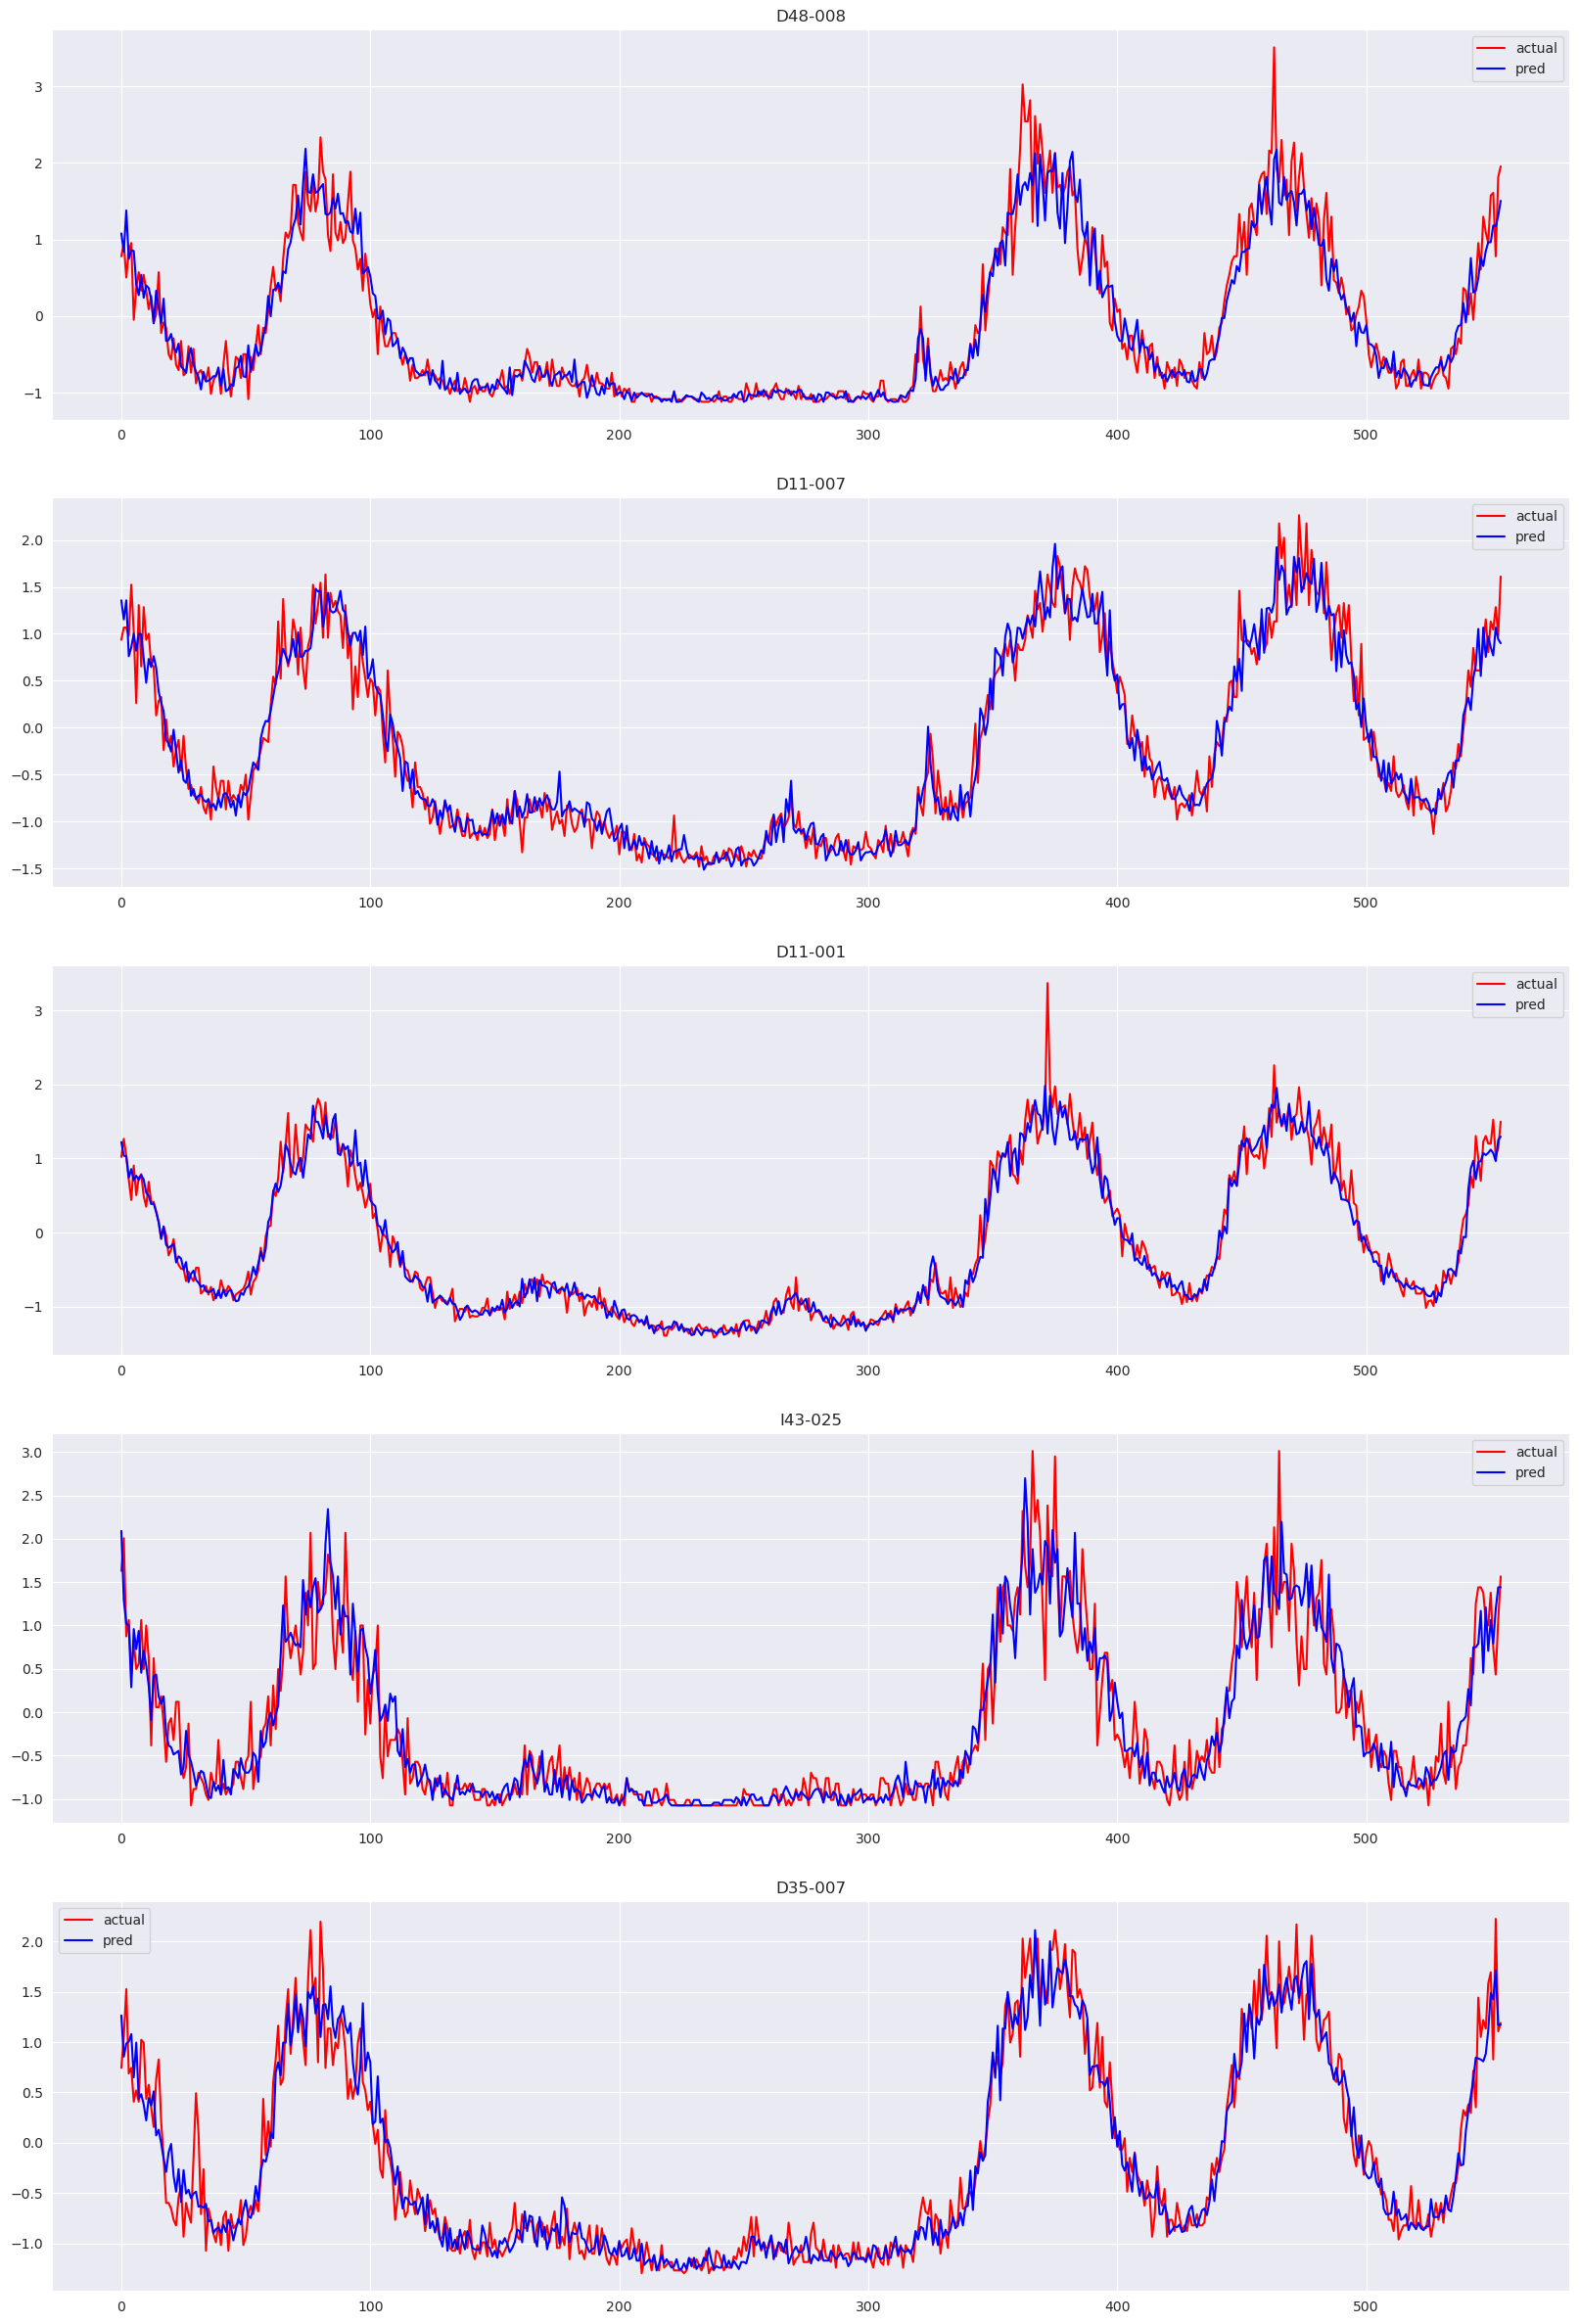

In [319]:
class PriorPredictionModel(nn.Module):
    def __init__(self, seq_len, in_channels, out_channels=1):
        super().__init__()
        self.window = seq_len
        self.in_channels = in_channels
        self.out_channels = out_channels

    def forward(self, X):
        return X.hist_average_y[-1]

model = PriorPredictionModel(seq_len=SEQ_LEN, in_channels=1).to(device)
model = run(model, results, num_epochs=0, plot=True, plot_update_freq=5)
evaluate_plot(model, test_ds)

**Linear Model**

Running LinR on every node, input for the regression - seq_len * in_features 

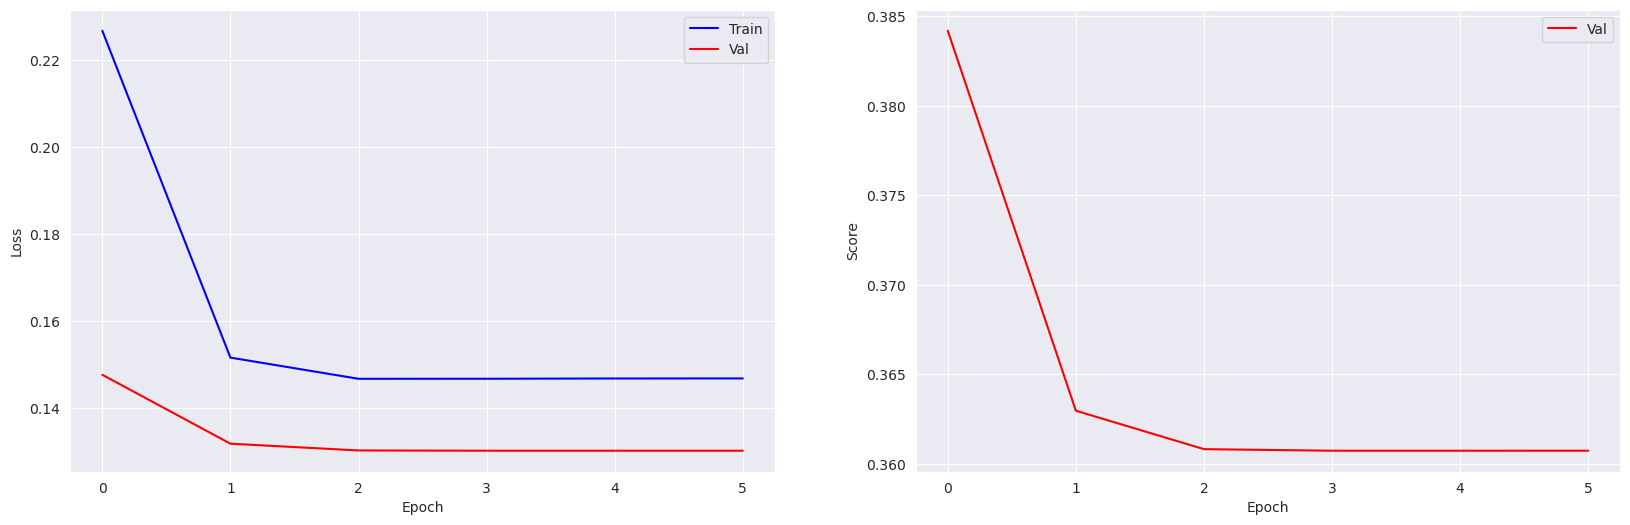

Type: LinearModel, Test loss: 0.12, Test score: 0.3492


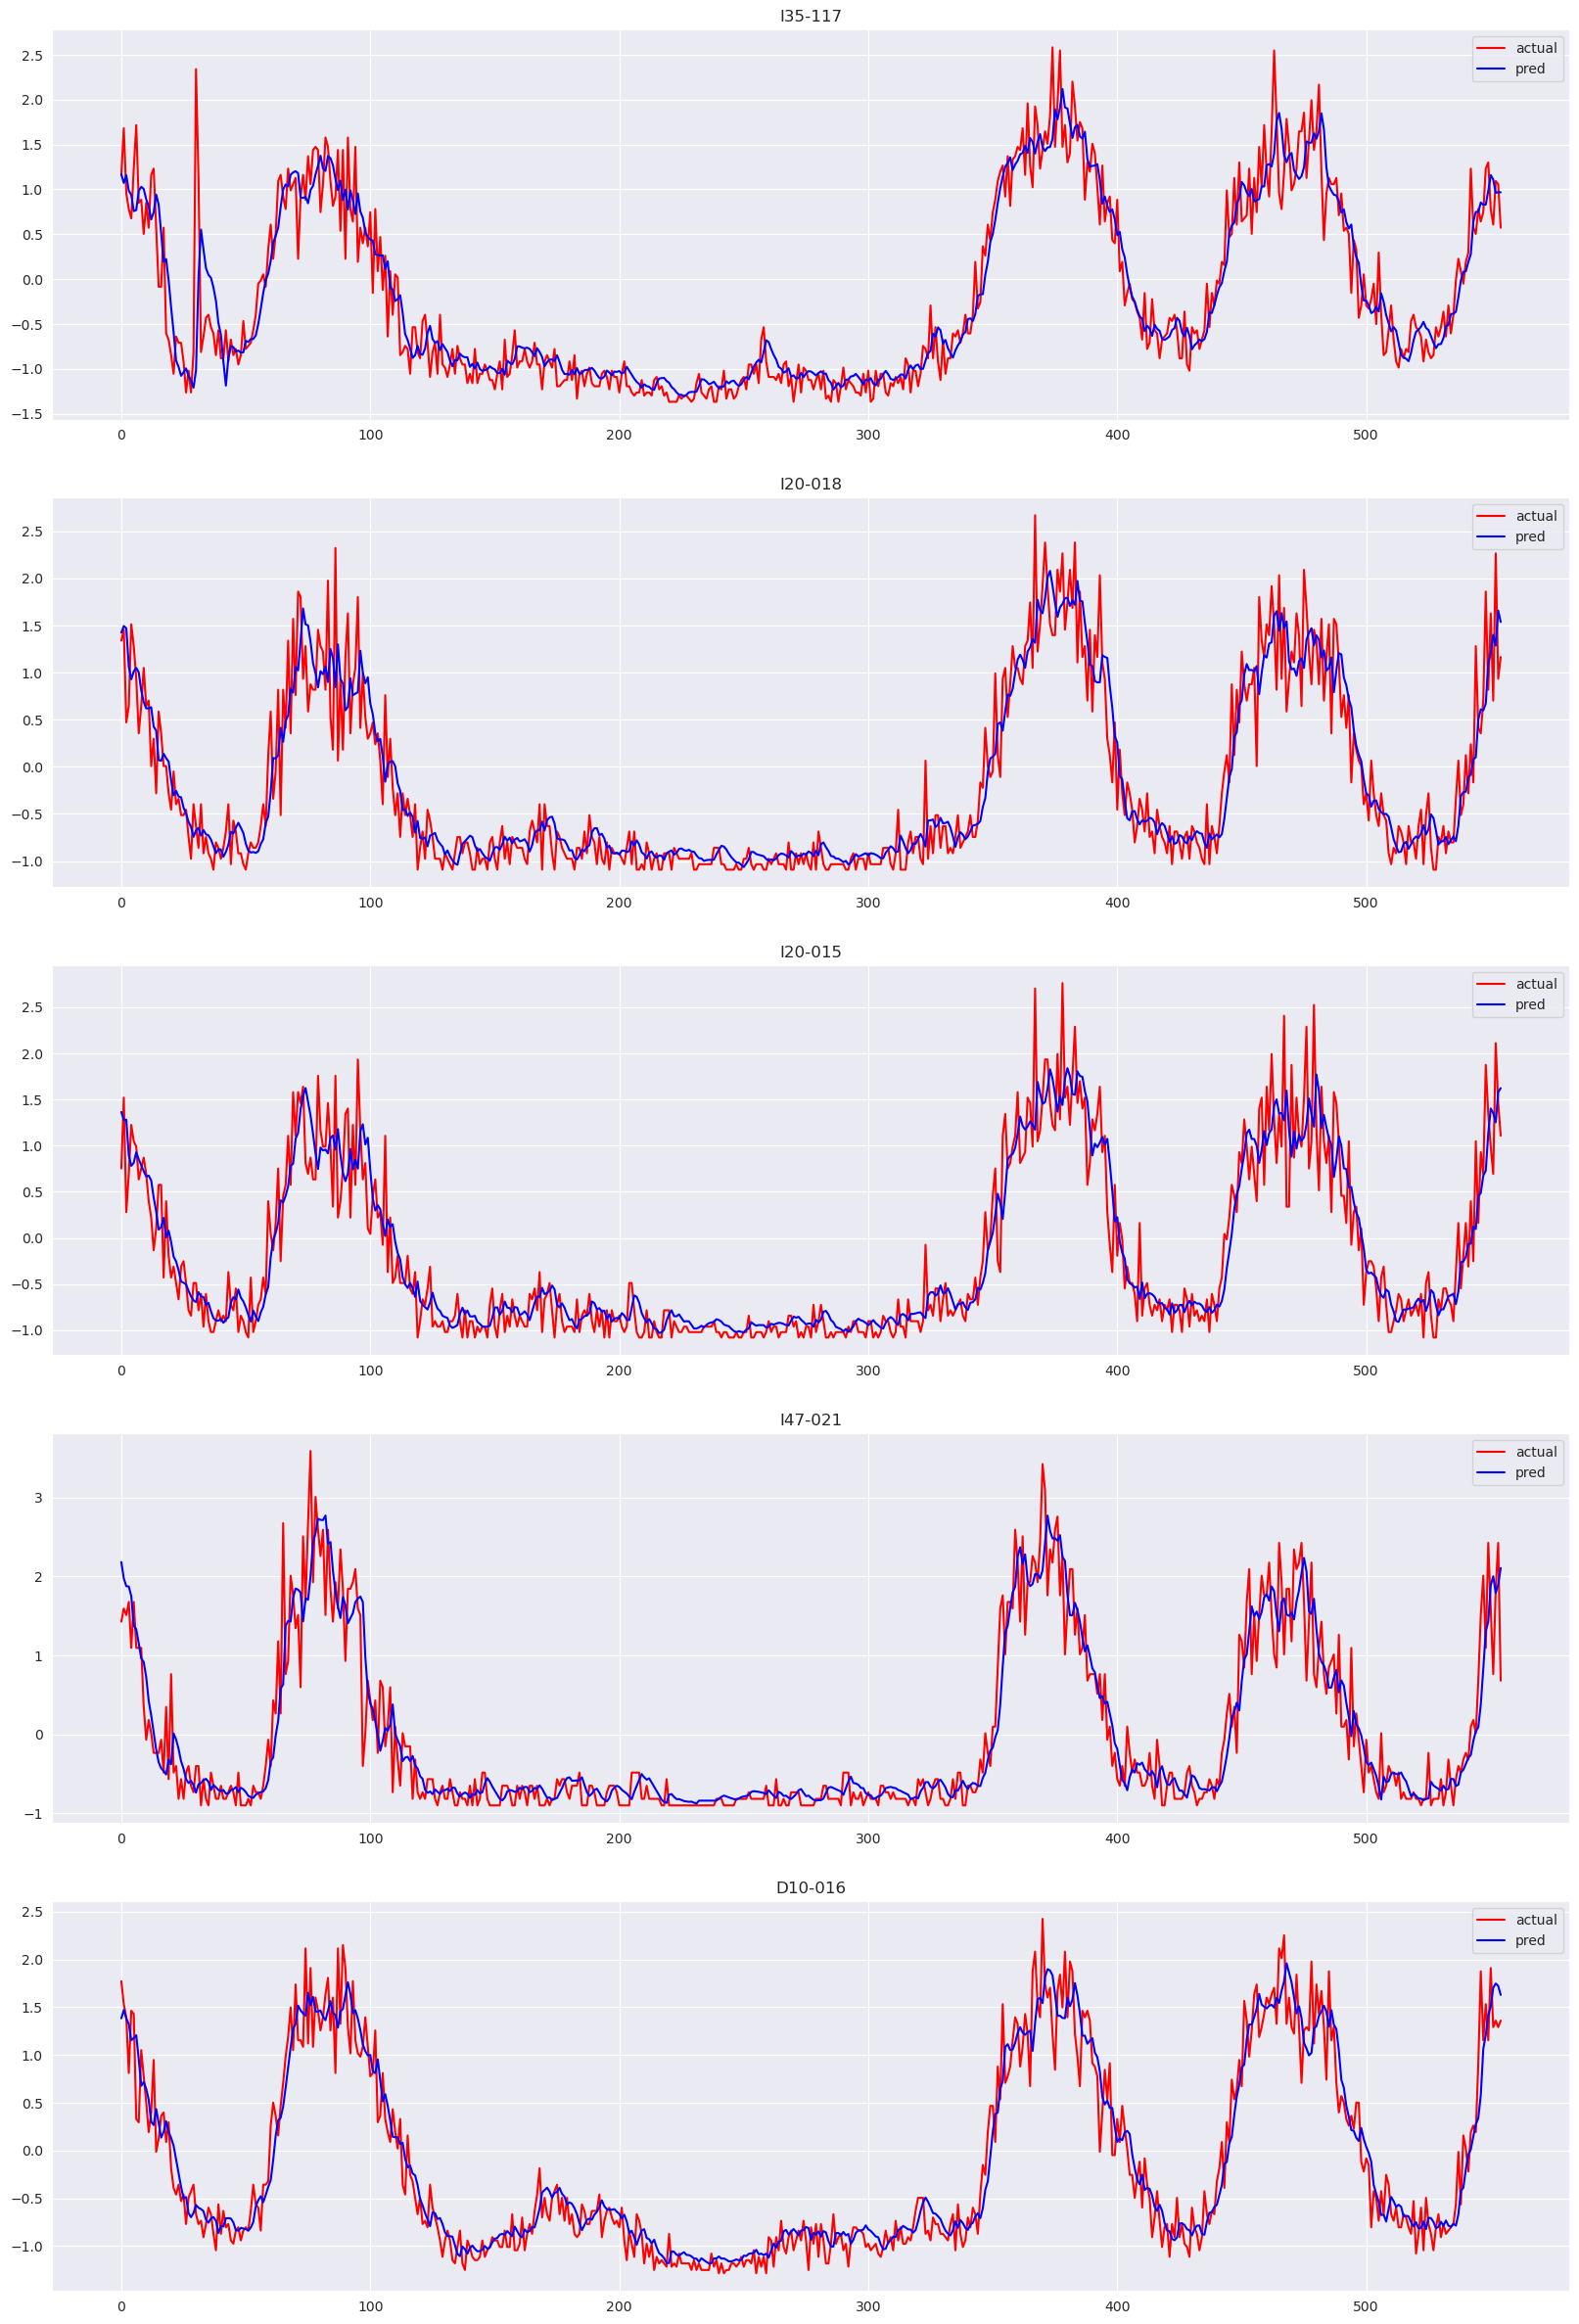

In [320]:
class LinearModel(nn.Module):
    def __init__(self, seq_len, in_channels, out_channels=1):
        super().__init__()
        self.window = seq_len
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.lin = nn.Linear(self.window * self.in_channels, self.out_channels, bias=True)
    
    def forward(self, X):
        X = X.y[:-1]
        X = X.transpose(0, 1)
        nodes_num = X.shape[0]
        X = X.reshape(nodes_num, -1)
        
        out = self.lin(X).squeeze(-1)
        return out

model = LinearModel(seq_len=SEQ_LEN, in_channels=1).to(device)
model = run(model, results, num_epochs=5, plot=True, plot_update_freq=5)
evaluate_plot(model, test_ds)

LSTM

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, seq_len=14, in_channels=1, hidden_size=32, num_layers=2, bidirectional=False, *args, **kwargs):
        super().__init__()
        self.in_channels = in_channels
        self.window = seq_len
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.rnn = nn.LSTM(input_size=self.in_channels, hidden_size=self.hidden_size, num_layers=self.num_layers,
            batch_first=True, bidirectional=self.bidirectional)
        self.lin = nn.Linear(self.hidden_size * (2 if self.bidirectional else 1), 1)
    
    def forward(self, X, *args, **kwargs):
        X = X.transpose(1, 2)
        batch_size = len(X)
        feats_num = X.shape[1]
        X = X.reshape(-1, self.window, self.in_channels)
        out, (hn, cn) = self.rnn(X)
        out = out[:, -1, :]
        out = out.reshape(batch_size, feats_num, -1)
        out = self.lin(out)
        return out

model = LSTMModel(seq_len=SEQ_LEN, in_channels=1).to(device)
model = run(model, results, lr=5e-4, num_epochs=15, plot=True, plot_update_freq=5)
evaluate_plot(model, test_loader, scaler)

**Time Attention with Time Features**

Running MLP on every node, input for the regression - seq_len * (in_features + dt_features)<br>
DT features are passed through MLP, before concatenating

In [ ]:
class Time2Vec(nn.Module):
    def __init__(self, in_features, out_features=32) -> None:
        super().__init__()
        self.out_features = out_features
        self.w0 = nn.parameter.Parameter(torch.randn(in_features, 1))
        self.b0 = nn.parameter.Parameter(torch.randn(1))
        self.w = nn.parameter.Parameter(torch.randn(in_features, out_features-1))
        self.b = nn.parameter.Parameter(torch.randn(out_features-1))
        self.f = torch.sin
    
    def forward(self, X):
        emb0 = torch.matmul(X, self.w0) + self.b0
        emb_periodic = self.f(torch.matmul(X, self.w) + self.b)
        return torch.cat([emb0, emb_periodic], -1)

In [ ]:
class VNNWithDtModel(nn.Module):
    def __init__(self, seq_len, in_channels=1, dt_dim=4, *args, **kwargs):
        super().__init__()
        self.window = seq_len
        self.in_channels = in_channels
        self.dt_dim = dt_dim
        self.hidden_dim = 64
        self.dt_new_dim = 32

        self.nn = nn.Sequential(
            nn.Linear(self.window * self.in_channels + self.dt_new_dim, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, 1)
        )

        # self.t2v = Time2Vec(dt_dim, 16)
        self.dt_nn = nn.Sequential(
            nn.Linear(dt_dim, 64),
            nn.ReLU(),
            nn.Linear(64, self.dt_new_dim)
        )
    
    def forward(self, X, X_dt, *args, **kwargs):
        X = X.transpose(1, 2)
        batch_size = X.shape[0]
        nodes_num = X.shape[1]

        # X_dt = self.t2v(X_dt)
        X_dt = self.dt_nn(X_dt)

        X_dt = X_dt[:, -1]
        X_dt = X_dt.unsqueeze(-1).expand(-1, -1, nodes_num).permute(0, 2, 1)

        X = X.reshape(batch_size, nodes_num, -1)
        X_dt = X_dt.reshape(batch_size, nodes_num, -1)

        input = torch.cat((X, X_dt), dim=-1)
        return self.nn(input)


# model = VNNWithDtModel(seq_len=SEQ_LEN, in_channels=1).to(device)
model = run(model, results, num_epochs=60, plot=True, plot_update_freq=5)
evaluate_plot(model, test_loader, scaler)

**VNN**

In [ ]:
class VNNModel(nn.Module):
    def __init__(self, seq_len=14, in_channels=1, *args, **kwargs):
        super().__init__()
        self.window = seq_len
        self.in_channels = in_channels
        self.hidden_dim = 64
        
        self.nn = nn.Sequential(
            nn.Linear(in_channels * self.window, self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.hidden_dim, 1)
        )
    
    def forward(self, X, X_dt, emb, *args, **kwargs):
        X = X.transpose(1, 2)
        batch_size = X.shape[0]
        nodes_num = X.shape[1]
        
        X = X.reshape(batch_size, nodes_num, -1)
        out = self.nn(X)
        return out

model = VNNModel(seq_len=SEQ_LEN, in_channels=1).to(device)
model = run(model, results, num_epochs=50, plot=True, plot_update_freq=5)
evaluate_plot(model, test_loader, scaler)

**VNN + Time Features + Node Embeddings**

In [ ]:
class VNN_WithDtEmbModel(nn.Module):
    def __init__(self, seq_len=14, in_channels=1, dt_dim=4, emb_dim=32, *args, **kwargs):
        super().__init__()
        self.window = seq_len
        self.in_channels = in_channels
        self.dt_dim = dt_dim
        self.emb_dim = emb_dim
        self.hidden_layer = 64

        self.emb_transformer = nn.Sequential(
            nn.Linear(self.emb_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )
        
        self.dt_transformer = nn.Sequential(
            nn.Linear(self.dt_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )

        self.nn = nn.Sequential(
            nn.Linear(32*2 + in_channels * self.window, self.hidden_layer),
            nn.ReLU(),
            nn.Linear(self.hidden_layer, 1))
    
    def forward(self, X, X_dt, emb, *args, **kwargs):
        X = X.transpose(1, 2)
        batch_size = X.shape[0]
        nodes_num = X.shape[1]
        
        emb = self.emb_transformer(emb)
        X_dt = self.dt_transformer(X_dt)

        X_dt = X_dt[:, -1]
        X_dt = X_dt.unsqueeze(-1).expand(-1, -1, nodes_num).permute(0, 2, 1)

        # print(X_dt.shape, X.shape)
        out = torch.cat((X_dt, emb, X.squeeze(-1)), dim=-1)
        out = self.nn(out)

        return out

# model = VNN_WithDtEmbModel(seq_len=SEQ_LEN, in_channels=1).to(device)
model = run(model, results, lr=5e-4, num_epochs=20, plot=True, plot_update_freq=5)
evaluate_plot(model, test_loader, scaler)

In [ ]:
import json
with open('results_att.json', mode='w') as f:
    json.dump(results, f, indent=4)

**Attention**

In [ ]:
import math

class PositionalEncoding(nn.Module):
    def __init__(self, dim: int, dropout: float = 0.1, max_len: int = 128):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, dim, 2) * (-math.log(10000.0) / dim))
        pe = torch.zeros(max_len, dim)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, seq_len: int) -> Tensor:
        """
        Args:
            seq_len: int
        Returns:
            x: Tensor, shape [seq_len, dim]
        """
        x = self.dropout(self.pe[:seq_len])
        return x

In [ ]:
pyg_data.edge_index

In [ ]:
%%time

class SpatioTemporalModule(pyg.nn.MessagePassing):
    def __init__(self, past_emb_dim, future_emb_dim, hidden_dim=64, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.hidden_dim = hidden_dim
        self.past_emb_dim = past_emb_dim
        self.future_emb_dim = future_emb_dim

        self.Q = nn.Linear(future_emb_dim, self.hidden_dim)
        self.K = nn.Linear(past_emb_dim, self.hidden_dim)
        self.V = nn.Linear(past_emb_dim, self.hidden_dim)
        # self.M = nn.Linear(future_emb_dim, self.hidden_dim)

        self.ffn = nn.Sequential(
            nn.Linear(self.hidden_dim, self.hidden_dim * 2),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(self.hidden_dim * 2, 1))

    def forward(self, past_emb, future_emb, edge_index):
        """Returns estimated targets for query nodes using scaling features and node embeddings.
        This function works utilizing message passing principle. For more information check the following link
        https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html

        Args:
            past_emb (torch.Tensor), shape [nodes_num, seq_len, past_emb_dim]: embeddings for the past observations
            future_emb (torch.Tensor), shape [nodes_num, future_emb_dim]: embeddings for the time T + 1
            edge_index (torch.Tensor): edges for the bipartite graph

        Returns:
            torch.Tensor, shape[nodes, 1]: estimated targets for nodes on T+1
        """

        # print(edge_index[:, :20])
        past_emb = past_emb.reshape(-1, past_emb.size(-1))

        q = self.Q(future_emb)
        k = self.K(past_emb)
        v = past_emb[:, :1]

        out = self.propagate(edge_index, 
            v=v, k=k, q=q, 
            size=(past_emb.size(0), future_emb.size(0)))
        
        # out = torch.cat([out, self.M(future_emb)], dim=-1)

        # out = self.ffn(out)

        return out

    def message(self, v_j, k_j, q_i, index):
        # print(x_j.shape, x_i.shape, index.shape)
        # k = self.K(x_j)
        # # v = self.V(x_j)
        # v = x_j[:, 0].unsqueeze(-1)
        # q = self.Q(x_i)

        logits = torch.sum(k_j * q_i, dim=1) / math.sqrt(self.hidden_dim)
        att_weights = pyg.utils.softmax(logits, index)
        # print(att_weights.shape, v.shape)
        # out = att_weights[:, None].expand(-1, self.hidden_dim) 
        out = att_weights[:, None] * v_j
        return out


class STATT(nn.Module):
    def __init__(self, seq_len=14, in_dim=1, dt_dim=4, emb_dim=32, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.window = seq_len
        self.in_dim = in_dim
        self.dt_dim = dt_dim
        self.emb_dim = emb_dim
        self.pos_enc_dim = 8
        self.hidden_layer = 16

        self.emb_transformer = nn.Sequential(
            nn.Linear(self.emb_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, self.emb_dim)

        )
        self.dt_transformer = nn.Sequential(
            nn.Linear(self.dt_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, self.dt_dim)
        )

        self.PE = PositionalEncoding(dim=self.pos_enc_dim)
        self.ST_Module = SpatioTemporalModule(past_emb_dim=in_dim + dt_dim + emb_dim,
            future_emb_dim=dt_dim + emb_dim)
    
    def _make_spatio_temporal_edge_index(self, edge_index, seq_len, device=device):
        # print(edge_index.shape)
        E, _ = pyg.utils.add_self_loops(edge_index)
        # print(E.shape)
        # E = edge_index
        # E = torch.vstack([torch.arange(0, 12), torch.arange(0, 12)]).to(device)
 
        out = torch.vstack([
            torch.cat([torch.arange(s * seq_len, (s + 1) * seq_len) for s in E[0]]).to(device),
            E[1][:, None].expand(-1, seq_len).reshape(-1)])

        return out

    def _make_temporal_edge_index(self, nodes_num, seq_len, device=device):
        return torch.vstack([
            torch.arange(0, nodes_num * seq_len, 1),
            torch.arange(0, nodes_num, 1)[:, None].expand(-1, seq_len).reshape(-1)]).to(device)

    def positional_encode(self, X):
        """Adds positional encoding to embeddings

        Args:
            X (Tensor), shape [batch_size, nodes_num, seq_len, emb_dim]
        Returns:
            out (Tensor), shape [batch_size, nodes_num, seq_len, emb_dim + pe_dim]
        """
        batch_size, nodes_num, seq_len, emb_dim = X.shape
        pe = torch.fliplr(self.PE(seq_len))[None, :].expand(batch_size * nodes_num, -1, -1)
        X = X.reshape(-1, seq_len, emb_dim)
        out = torch.cat([X, pe], dim=-1).reshape(batch_size, nodes_num, seq_len, emb_dim + self.pos_enc_dim)
        return out

    def compose_future_emb(self, X_dt, node_embs):
        X_tp1 = X_dt[:, :, -1]
        X_future = torch.cat((X_tp1, node_embs), dim=-1)
        return X_future
    
    def compose_past_emb(self, X, X_dt, node_embs):
        past_dt = X_dt[:, :, :-1]
        X_past = torch.cat(
            (X,
             past_dt,
             node_embs.unsqueeze(-1).expand(-1, -1, -1, self.window).permute(0, 1, 3, 2)),
        dim=-1)
        # out = self.positional_encode(X_past)
        out = X_past
        # print(out.shape)
        return out

    def forward(self, X, X_dt, emb, edge_index, *args, **kwargs):
        X = X.transpose(1, 2)
        batch_size = X.shape[0]
        nodes_num = X.shape[1]

        # print(X.shape, X_dt.shape, emb.shape)
        
        # learning new embeddings
        emb = self.emb_transformer(emb)
        X_dt = self.dt_transformer(X_dt)

        X_dt = X_dt.unsqueeze(-1).expand(-1, -1, -1, nodes_num).permute(0, 3, 1, 2)
        
        past_emb = self.compose_past_emb(X, X_dt, emb)
        future_emb = self.compose_future_emb(X_dt, emb)

        # print(past_emb.shape, future_emb.shape)

        # edge_index = self._make_temporal_edge_index(past_emb.shape[1], past_emb.shape[2])
        edge_index = self._make_spatio_temporal_edge_index(edge_index[0], past_emb.shape[2])

        torch_streams = [torch.cuda.Stream() for _ in range(batch_size)]
        torch.cuda.synchronize()
        batch_res = []
        for i, s in enumerate(torch_streams):
            with torch.cuda.stream(s):
                batch_res.append(self.ST_Module(past_emb[i], future_emb[i], edge_index))
        torch.cuda.synchronize()

        out = torch.hstack(batch_res).T
        out = out.unsqueeze(-1)
        return out

model = STATT(seq_len=SEQ_LEN, in_dim=1).to(device)
model = run(model, results, lr=1e-3, num_epochs=30, plot=True, plot_update_freq=1)
evaluate_plot(model, test_loader, scaler)